Задача от 19 ноября

# TZ

1. На базе HorsesOrHumans (которая есть в открытом доступе библиотеки tensorflow) постройте автокодировщик. 
2. Предобучите автокодировщик. Возьмите
предобученный encoder. 
3. Кластеризуйте скрытое пространство на два кластера,
полученное из encoder (т.е. кластеризовать изображения, так как при подаче изображения на вход encoder’у получится скрытое пространство).
4. Проверьте насколько точно произошла кластеризация картинок лошадей и людей
по двум классам.

Мы не ждём от Вас высокой точности сети, это будет проверка на
взаимодействие, понимание задания и подход к обработке базы.


# Import

In [1]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, Dropout, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # базовые керасовские функции
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 

import matplotlib.pyplot as plt # для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np 
import pandas as pd 
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # для стандартизации данных

import os
from google.colab import drive 
import time

In [2]:
import pylab # для построения графиков
# выводить изображения в ноутбуке, а не в консоль или файл
%matplotlib inline 

In [3]:
drive.mount('/content/drive/') 

Mounted at /content/drive/


# Автокодировщик


## Функции

In [4]:
def baseAutoencoder(shape=(300,300,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    
    # слой разжимает данные
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x)

    # слой разжимает данные
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) 

    # Финальный слой двумерной свертки
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и MSE

    return model # функция вернёт заданную модель

In [96]:
def plotImages(xTrain, pred, shape=(300, 300)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(10, 10)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n=5
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере shape      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере shape     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [97]:
def plotImages2(xTrain, pred, shape=(300, 300), shape2=(75,75)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(10, 10)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере shape      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape2)) # отрисуем картинки в размере 75*75     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [7]:
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [8]:
# функция загрузки изображений
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [9]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1]) 
x2 = np.array([0, 0, 0]) 
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

1.0


## Подготовка

In [10]:
%%time
# Распаковываем лошадей
!unzip -q '/content/drive/My Drive/Colab Notebooks/Базы/horse-or-human.zip' # распоковываем базу в colaboratory

CPU times: user 10.5 ms, sys: 6.65 ms, total: 17.2 ms
Wall time: 3.93 s


In [11]:
images_dir = 'train/horses' # зададим имя папки в которую распоковали изображения
img_height = 300 # зададим высоту изображений
img_width = 300 # зададим ширину избражений

images_dir75 = 'train/horses' # зададим имя папки в которую распоковали изображения
img_height75 = 75 # зададим высоту изображений
img_width75 = 75 # зададим ширину избражений

In [12]:
cur_time = time.time() 
xTrain_imag = load_images(images_dir, img_height, img_width) # загрузим избражения 300*300
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

Время загрузки: 3.04с


In [13]:
cur_time = time.time() 
yTrain_imag = load_images(images_dir75, img_height75, img_width75) # загрузим избражения 75*75
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

Время загрузки: 2.82с


In [14]:
xTrain_img = xTrain_imag/255 # отнормируем изображения 
yTrain_img = yTrain_imag/255

In [15]:
xTrain_img.shape # выведем размерность

(500, 300, 300, 1)

In [16]:
yTrain_img.shape

(500, 75, 75, 1)

## Horse. Часть 0. 300 -> 75 -> 300
Автоэнкодер как в уроке 9

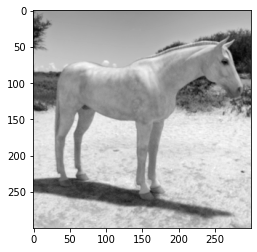

In [ ]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(300,300), cmap='gray') #выведем случайное изображение
plt.show()

In [ ]:
modelAutoFace = baseAutoencoder() # создаем автокодировщик
# грузим данные в нашу модель, берём первые 460 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img
modelAutoFace.fit(xTrain_img[:460], xTrain_img[:460], epochs=150, validation_data = (xTrain_img[460:], xTrain_img[460:]))

Epoch 1/150
15/15 [==============================] - 10s 679ms/step - loss: 0.0689 - val_loss: 0.0779
Epoch 2/150
15/15 [==============================] - 9s 622ms/step - loss: 0.0260 - val_loss: 0.0775
Epoch 3/150
15/15 [==============================] - 9s 605ms/step - loss: 0.0172 - val_loss: 0.0775
Epoch 4/150
15/15 [==============================] - 9s 593ms/step - loss: 0.0126 - val_loss: 0.0770
Epoch 5/150
15/15 [==============================] - 9s 585ms/step - loss: 0.0094 - val_loss: 0.0770
Epoch 6/150
15/15 [==============================] - 9s 583ms/step - loss: 0.0076 - val_loss: 0.0763
Epoch 7/150
15/15 [==============================] - 9s 585ms/step - loss: 0.0068 - val_loss: 0.0770
Epoch 8/150
15/15 [==============================] - 9s 585ms/step - loss: 0.0060 - val_loss: 0.0746
Epoch 9/150
15/15 [==============================] - 9s 591ms/step - loss: 0.0051 - val_loss: 0.0733
Epoch 10/150
15/15 [==============================] - 9s 593ms/step - loss: 0.0051 - val_l

In [ ]:
modelAutoFace.save_weights('modelAutoFace.h5')
modelAutoFace.load_weights('modelAutoFace.h5') 

In [ ]:
predFace = modelAutoFace.predict(xTrain_img[:100]) # сделаем предикт для первых ста картинок

predFace = predFace * 255 # представляем в виде значений от 0 до 255
predFace = predFace.astype('uint8') # устанавливаем 8битовый тип

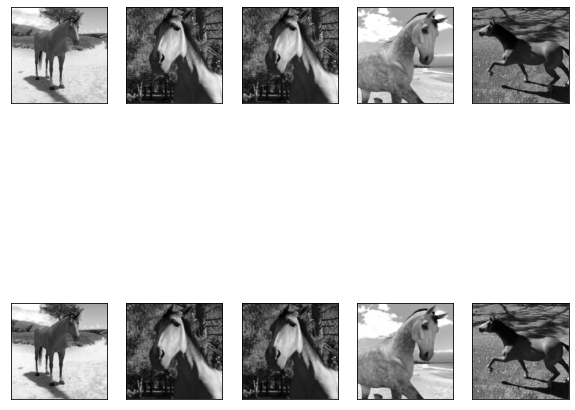

In [ ]:
plotImages(xTrain_img, predFace) #выведем оригинальные и сгенерированные автокодировщиком

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их 
errFace = [getMSE(xTrain_img[i], predFace[i] / 255) for i in range(len(predFace))] # посчитаем ошибку для всех изображений
print("Ошибка на лошадях:", errFace[80:]) #посмотрим последнии 20
print("Средняя ошибка на лошадях:", round(sum(errFace[80:]) / len(errFace[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на лошадях:", round(min(errFace),4)) #найдем минимальную ошибку

Ошибка на лошадях: [0.0010393381460817607, 0.0006163348343274977, 0.0005675960140231006, 0.0008710246002512597, 0.0011021831572588718, 0.0013613250818040748, 0.0005008192654761355, 0.0007964870835828825, 0.0008783210764179701, 0.0006390472157404581, 0.0010190605102916622, 0.0008428917715959996, 0.0007651054972001033, 0.0008988437833456474, 0.000740064561113337, 0.0009594264805309394, 0.0009573262173588046, 0.0006473014366765881, 0.0009714319811371685, 0.0005714350791724431]
Средняя ошибка на лошадях: 0.0008
Минимальная ошибка на лошадях: 0.0004


In [ ]:
bias = 0.0004 # установим пороговое значение

isFace = [e < bias for e in errFace[80:]] # запишем каждую ошибку больше порогового значения

print("Лошади распознаны, как лошади: ", round(100*sum(isFace) / len(isFace)),"%", sep="")

Лошади распознаны, как лошади: 0.0%


## Часть 1. Cжатие (300 -> 75)

In [18]:
def baseAutoencoder3(shape=(300,300,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    # передаем на слой двумерной свёртки
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x) 
    
    # Финальный слой двумерной свертки, выдающий итоговое изображение
    z = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(z)

    model = Model(img_input, z) # указываем модель, с оригинальным изображением на входе в сеть и сжатым на выходе из сети
    model.compile(optimizer='adam',
                  loss='mse')

    return model 

In [28]:
%%time
modelAutoHorse = baseAutoencoder3() # создаем автокодировщик
# грузим данные в нашу модель, берём первые 460 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img
modelAutoHorse.fit(xTrain_img[:460], yTrain_img[:460], epochs=70, validation_data = (xTrain_img[460:], yTrain_img[460:]))

Epoch 1/70
15/15 [==============================] - 4s 247ms/step - loss: 0.0368 - val_loss: 0.0685
Epoch 2/70
15/15 [==============================] - 3s 229ms/step - loss: 0.0068 - val_loss: 0.0705
Epoch 3/70
15/15 [==============================] - 3s 229ms/step - loss: 0.0031 - val_loss: 0.0729
Epoch 4/70
15/15 [==============================] - 3s 231ms/step - loss: 0.0025 - val_loss: 0.0723
Epoch 5/70
15/15 [==============================] - 3s 232ms/step - loss: 0.0030 - val_loss: 0.0744
Epoch 6/70
15/15 [==============================] - 4s 234ms/step - loss: 0.0022 - val_loss: 0.0719
Epoch 7/70
15/15 [==============================] - 4s 234ms/step - loss: 0.0025 - val_loss: 0.0704
Epoch 8/70
15/15 [==============================] - 4s 236ms/step - loss: 0.0029 - val_loss: 0.0679
Epoch 9/70
15/15 [==============================] - 4s 238ms/step - loss: 0.0024 - val_loss: 0.0668
Epoch 10/70
15/15 [==============================] - 4s 238ms/step - loss: 0.0019 - val_loss: 0.0643

In [19]:
# Сохраняем модель]
#modelAutoHorse.save_weights('modelAutoHorse.h5')
modelAutoHorse = baseAutoencoder3()
modelAutoHorse.load_weights('modelAutoHorse2.h5') 

## Часть 2. Уменьшаем все картинки

In [20]:
%%time
# Уменьшаем картинки через предикт
prediction = modelAutoHorse.predict(xTrain_img)

CPU times: user 2.84 s, sys: 1.5 s, total: 4.35 s
Wall time: 8.6 s


In [21]:
predHorse = modelAutoHorse.predict(xTrain_img[:100]) # сделаем предикт для первых ста картинок

predHorse = predHorse * 255 # представляем в виде значений от 0 до 255
predHorse = predHorse.astype('uint8') # устанавливаем 8битовый тип

In [22]:
# Проверяем размеры
print(len(prediction), len(predHorse[0]))

500 75


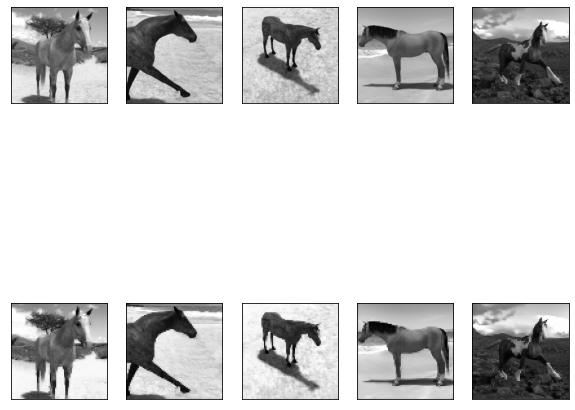

In [99]:
# Печатаем исходные и конечные картинки
plotImages2(xTrain_img, predHorse) 

In [24]:
# функция загрузки изображений
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [25]:
images_i = ('train/horses', 'train/humans', 'validation/horses', 'validation/humans') 
img_height = 300 # зададим высоту изображений
img_width = 300 # зададим ширину избражений

In [38]:
%%time
# Делаем предобработку данных в обучающие и тестовые]
xTrain1 = load_images(images_i[0], img_height, img_width)
xTrain2 = load_images(images_i[1], img_height, img_width)[:500]
xTest1 = load_images(images_i[2], img_height, img_width)
xTest2 = load_images(images_i[3], img_height, img_width)

print ([len(i) for i in [xTrain1, xTrain2, xTest1, xTest2]])

xTrainM1 = modelAutoHorse.predict(xTrain1)
xTrainM2 = modelAutoHorse.predict(xTrain2)
xTestM1 = modelAutoHorse.predict(xTest1)
xTestM2 = modelAutoHorse.predict(xTest2)

print ([len(i) for i in [xTrainM1, xTrainM2, xTestM1, xTestM2]])
print ([type(i) for i in [xTrainM1, xTrainM2, xTestM1, xTestM2]])

[500, 500, 128, 128]
[500, 500, 128, 128]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
CPU times: user 8.06 s, sys: 1.17 s, total: 9.23 s
Wall time: 9.09 s


**Подготавливаем обучающие и тестовые данные**

In [39]:
# horses - 0, humans - 1
yTrain1 = [0]*len(xTrain1)
yTrain2 = [1]*len(xTrain2)
yTest1 = [0]*len(xTest1)
yTest2 = [1]*len(xTest2)
print ([len(i) for i in [yTrain1, yTrain2, yTest1, yTest2]])
print ([type(i) for i in [yTrain1, yTrain2, yTest1, yTest2]])

[500, 500, 128, 128]
[<class 'list'>, <class 'list'>, <class 'list'>, <class 'list'>]


In [40]:
xTrain = np.array(list(xTrainM1) + list(xTrainM2))
yTrain = yTrain1 + yTrain2
xTest = np.array(list(xTestM1) + list(xTestM2))
yTest = yTest1 + yTest2
print ([len(i) for i in [xTrain, yTrain, xTest, yTest]])
print ([type(i) for i in [xTrain, yTrain, xTest, yTest]])

[1000, 1000, 256, 256]
[<class 'numpy.ndarray'>, <class 'list'>, <class 'numpy.ndarray'>, <class 'list'>]


## Часть 3. Кластеризатор

In [41]:
# Проверяем тестовые и обучающие данные 
print([len(i) for i in [xTrain, yTrain, xTest, yTest]])
print ([type(i) for i in [xTrain, yTrain, xTest, yTest]])

[1000, 1000, 256, 256]
[<class 'numpy.ndarray'>, <class 'list'>, <class 'numpy.ndarray'>, <class 'list'>]


In [42]:
#Определяем названия классов
classes = ['horses', 'humans']

In [113]:
def plotImages3(pred, n=1, shape2 =(75,75)): # создадим функцию для вывода изображений как картинок
  n = n  # количество картинок, которые хотим показать
  plt.figure(figsize=(10, 10)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape2)) # отрисуем обработанные сеткой картинки в размере shape     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [ ]:
# Печатаем картинку
plotImages3(xTrain, 1) 

In [45]:
#Превращаем y_train и y_test сетей в формат one hot encoding
x_train10 = utils.to_categorical(xTrain)
x_test10 = utils.to_categorical(xTest)
y_train10 = utils.to_categorical(yTrain, 2)
y_test10 = utils.to_categorical(yTest, 2)

# Cмотрим размеры выборок перед обучением
print(x_train10.shape, type(x_train10))
print(x_test10.shape, type(x_test10))
print(y_train10.shape, type(y_train10))
print(y_test10.shape, type(y_test10))

(1000, 75, 75, 2) <class 'numpy.ndarray'>
(256, 75, 75, 2) <class 'numpy.ndarray'>
(1000, 2) <class 'numpy.ndarray'>
(256, 2) <class 'numpy.ndarray'>


In [58]:
x_train10[0][12][0]

array([0., 1.], dtype=float32)

**Нейронная сеть**

*Разбор данного раздела:* https://youtu.be/wvScQNvuZ8c?t=6070



Epoch 1/500
8/8 [==============================] - 1s 92ms/step - loss: 1.1334 - accuracy: 0.6580 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/500
8/8 [==============================] - 1s 63ms/step - loss: 0.5135 - accuracy: 0.7950 - val_loss: 0.6812 - val_accuracy: 0.6094
Epoch 3/500
8/8 [==============================] - 1s 63ms/step - loss: 0.3822 - accuracy: 0.8320 - val_loss: 0.6865 - val_accuracy: 0.6250
Epoch 4/500
8/8 [==============================] - 0s 62ms/step - loss: 0.3223 - accuracy: 0.8540 - val_loss: 0.6820 - val_accuracy: 0.6016
Epoch 5/500
8/8 [==============================] - 1s 63ms/step - loss: 0.2862 - accuracy: 0.8710 - val_loss: 0.6855 - val_accuracy: 0.5000
Epoch 6/500
8/8 [==============================] - 1s 63ms/step - loss: 0.2464 - accuracy: 0.8820 - val_loss: 0.6835 - val_accuracy: 0.5039
Epoch 7/500
8/8 [==============================] - 0s 62ms/step - loss: 0.2275 - accuracy: 0.8880 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 8/500
8/8 [===

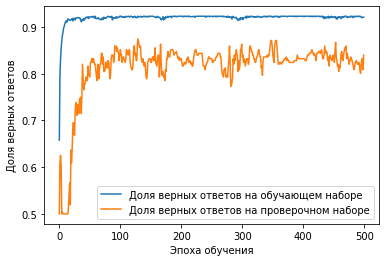

In [101]:
# создаем сеть
batch_size = 128 
model = Sequential()
model.add(BatchNormalization(input_shape=(75, 75, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

#Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Обучаем сеть на данных
history = model.fit(x_train10, 
                    y_train10, 
                    batch_size=batch_size, 
                    epochs=500,
                    validation_data=(x_test10, y_test10),
                    verbose=1)

#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [119]:
model.save_weights('modelClassifierHorse.h5')

In [64]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, 75, 75, 2)         8         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 75, 75, 32)        608       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 37, 37, 64)       

## **Проверяем на тестовой выборке**


In [65]:
#Распознаём тестовые картинки
predictionEnd = model.predict(x_test10)

In [76]:
#Выбираем пример
n = 240

#Выводим результаты
print("Выход сети: ", predictionEnd[n])
print("Распознанный образ: ", np.argmax(predictionEnd[n]))
print("Верный ответ: ", y_test10[n])
print("Распознанный образ на картинке: ", classes[np.argmax(predictionEnd[n])])

Выход сети:  [1.244804e-09 1.000000e+00]
Распознанный образ:  1
Верный ответ:  [0. 1.]
Распознанный образ на картинке:  humans


In [106]:
n = -129

print("Выход сети: ", predictionEnd[n])
print("Распознанный образ: ", np.argmax(predictionEnd[n]))
print("Верный ответ: ", y_test10[n])
print("Распознанный образ на картинке: ", classes[np.argmax(predictionEnd[n])])

Выход сети:  [0.66314036 0.33685964]
Распознанный образ:  0
Верный ответ:  [1. 0.]
Распознанный образ на картинке:  horses
